<a href="https://colab.research.google.com/github/mohammed-444/GI-Tract-Image-Segmentation/blob/main/Stomach_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from numpy import load
import matplotlib.pyplot as plt
from numpy import save
import numpy as np
import cv2
import tensorflow as tf
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [2]:
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [3]:
!gdown 1uXiy-o5VAA3ELA_7BShrdt6UF48u464i

Downloading...
From: https://drive.google.com/uc?id=1uXiy-o5VAA3ELA_7BShrdt6UF48u464i
To: /content/imgs_stomach_GI.npy
100% 3.39G/3.39G [00:31<00:00, 107MB/s]


In [4]:
!gdown 1-B9HBunN5mFOAdQoR3mmrt99j772DOmj

Downloading...
From: https://drive.google.com/uc?id=1-B9HBunN5mFOAdQoR3mmrt99j772DOmj
To: /content/stomach_masks_GI.npy
100% 1.13G/1.13G [00:09<00:00, 125MB/s] 


In [5]:
datagen = ImageDataGenerator(validation_split=0.2)
training_generator = datagen.flow(np.load('/content/imgs_stomach_GI.npy'), np.load('/content/stomach_masks_GI.npy'), batch_size=64,subset='training',seed=7)
validation_generator = datagen.flow(np.load('/content/imgs_stomach_GI.npy'), np.load('/content/stomach_masks_GI.npy'), batch_size=64,subset='validation',seed=7)

In [6]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    
    
    ### START CODE HERE
    
    
    
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
      conv= Dropout(dropout_prob) (conv)
         ### START CODE HERE
        
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
      next_layer=MaxPooling2D((2, 2),strides=2) (conv)
        ### START CODE HERE
        
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [7]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up=Conv2DTranspose(n_filters, 3, strides=2, padding='same') (expansive_input)
    conv=concatenate([up, contractive_input], axis=3)
    conv=Conv2D(n_filters, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    conv=Conv2D(n_filters, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    
    ### END CODE HERE
    
    return conv

In [18]:
def unet_model(input_size=(128, 128, 3), n_filters=32, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    
    
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block 
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    
    
    
    ### END CODE HERE
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block 
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [19]:
img_height = 128
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [10]:
# unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

In [53]:
from tensorflow.keras.losses import BinaryCrossentropy

def loss_f(y_true, y_pred):
    bce = BinaryCrossentropy()
    return dice_loss(y_true, y_pred) + bce(y_true, y_pred)
    
def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [54]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def iou_coef(y_true, y_pred, smooth = 1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1])
    union = K.sum(y_true,[1])+K.sum(y_pred,[1])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [30]:
unet = unet_model()
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                   loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['accuracy'])
# unet.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2, verbose = 1)

In [22]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_61 (Conv2D)             (None, 128, 128, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 64, 64, 32)  0           ['conv2d_61[0][0]']              
 )                                                                                          

In [32]:
EPOCHS = 18
history = unet.fit( training_generator,
                         validation_data = validation_generator, 
                         epochs = EPOCHS, callbacks = [early_stop, reduce_lr])

Epoch 1/18
108/108 [==============================] - 34s 307ms/step - loss: 0.1348 - accuracy: 0.9805 - val_loss: 0.0612 - val_accuracy: 0.9853 - lr: 1.0000e-04
Epoch 2/18
108/108 [==============================] - 33s 310ms/step - loss: 0.0475 - accuracy: 0.9835 - val_loss: 0.0444 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 3/18
108/108 [==============================] - 33s 309ms/step - loss: 0.0397 - accuracy: 0.9839 - val_loss: 0.0419 - val_accuracy: 0.9856 - lr: 1.0000e-04
Epoch 4/18
108/108 [==============================] - 34s 310ms/step - loss: 0.0339 - accuracy: 0.9857 - val_loss: 0.0362 - val_accuracy: 0.9871 - lr: 1.0000e-04
Epoch 5/18
108/108 [==============================] - 34s 311ms/step - loss: 0.0298 - accuracy: 0.9871 - val_loss: 0.0363 - val_accuracy: 0.9866 - lr: 1.0000e-04
Epoch 6/18
108/108 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9882
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
108/108 [=========

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']




epochs = range(1, len(loss) + 1)

plt.figure(figsize=(20, 5))



plt.show()

<Figure size 1440x360 with 0 Axes>

In [40]:
X, y = validation_generator[0]
pred = unet.predict(X)

2/2 [==============================] - 0s 67ms/step


In [41]:
pred.shape

(64, 128, 128, 1)

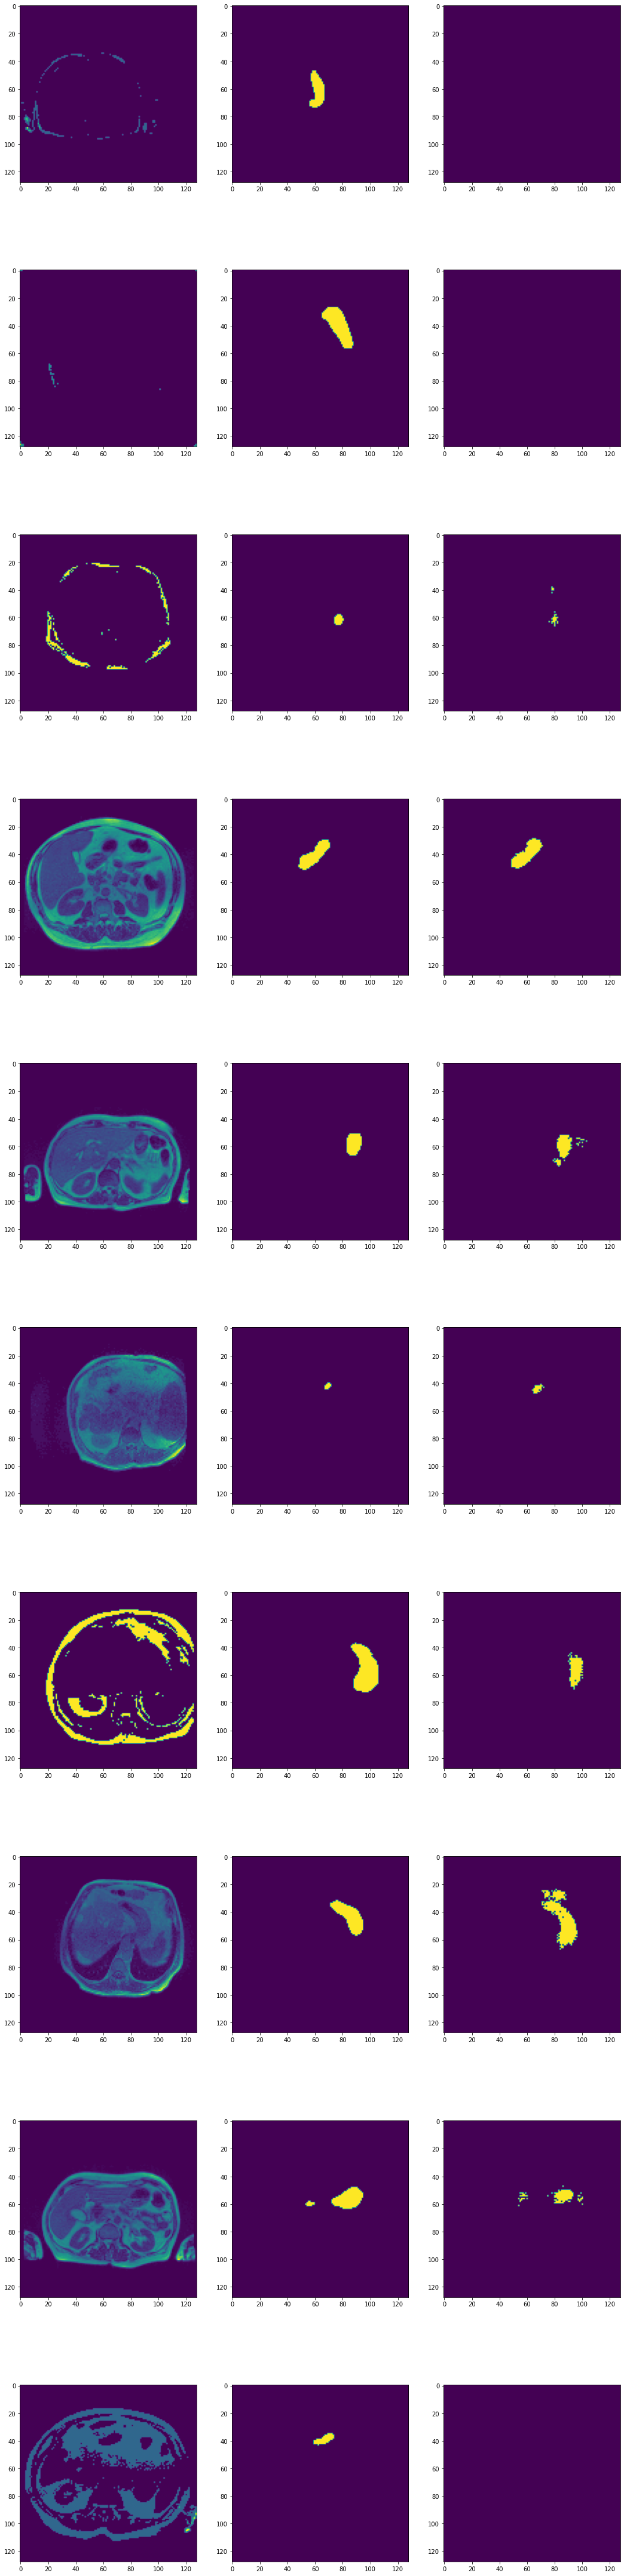

In [52]:
num = 10
fig, ax = plt.subplots(num,3, figsize=(18, 8 * num))

for i in range(num):
    img = X[i, :, :, 0]
    masks = y[i]
    pred_masks = pred[i]
    ax[i, 0].imshow(img)
    
    mask = np.zeros(masks.shape[:-1])
    m = masks[:, :, 0]
    # mask = m/4*np.max(img)
    ax[i, 1].imshow(m)
    
    pred_mask = np.zeros(masks.shape[:-1])
    m = (pred_masks[:, :, 0] > 0).astype(np.float32)
    # pred_mask = m/4*np.max(img)
    ax[i, 2].imshow(m)
